In [1]:
import psycopg2
from config import local_host, local_name, local_port, local_user
from creds import local_db_password
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time

from sim_v1 import simulate

warnings.simplefilter('ignore')
conn = psycopg2.connect(dbname=local_name, user =local_user, host=local_host, password=local_db_password, port =local_port)
cur = conn.cursor()

In [2]:
def check_roll_params(setup=None, param_name='rolling_params'):
    total = 0
    for key in setup[param_name]:
        total += setup[param_name][key]
    print(total)

In [3]:
real_results_sql = """

select 
	fixture_id,
	max(team_id) filter (where team_id = team_home) as team_home,
	max(team_id) filter (where team_id = team_away) as team_away,
	max(goals_total) filter (where team_id = team_home) as home_goal,
	max(goals_total) filter (where team_id = team_away) as away_goal,
	max(shots_total) filter (where team_id = team_home) as home_shot,
	max(shots_total) filter (where team_id = team_away) as away_shot,
	max(passes_total) filter (where team_id = team_home) as home_passes,
	max(passes_total) filter (where team_id = team_away) as away_passes,
	max(dribbles_total) filter (where team_id = team_home) as home_dribble,
	max(dribbles_total) filter (where team_id = team_away) as away_dribble
	
from (
select
	fixture_id,
	team_id,
	sum(goals_total::int) as goals_total,
	sum(shots_total::int) as shots_total,
	sum(passes_total::int) as passes_total,
	sum(tackles_total::int) as total_tackles,
	sum(interceptions::int) as interceptions,
	sum(blocks::int) as blocks,
	sum(dribbles_attempted::int) as dribbles_total
from ffl.fixture_player_performance
group by fixture_id, team_id) a
left join ffl.fixtures as fix on fix.id = fixture_id
group by 1
"""



In [4]:
fixtures_sql = """
select id, score_home, score_away from ffl.fixtures
"""
fixtures_list = []
cur.execute(fixtures_sql)
for fix in cur.fetchall():
    fixtures_list.append(fix[0])

In [5]:
def confusion_matrix(true_results=None, pred_results=None):
    pred_win_true_win = 0
    pred_win_true_loss = 0
    pred_win_true_tie = 0
    pred_loss_true_win = 0
    pred_loss_true_loss = 0
    pred_loss_true_tie = 0
    pred_tie_true_win = 0
    pred_tie_true_loss = 0
    pred_tie_true_tie = 0
    

    for row in range(len(true_results)):
        if pred_results.iloc[row]['home_goal'] > pred_results.iloc[row]['away_goal'] and true_results.iloc[row]['home_goal'] > true_results.iloc[row]['away_goal']:
            pred_win_true_win += 1
        elif pred_results.iloc[row]['home_goal'] > pred_results.iloc[row]['away_goal'] and true_results.iloc[row]['home_goal'] < true_results.iloc[row]['away_goal']:
            pred_win_true_loss += 1.
        elif pred_results.iloc[row]['home_goal'] > pred_results.iloc[row]['away_goal'] and true_results.iloc[row]['home_goal'] == true_results.iloc[row]['away_goal']:
            pred_win_true_tie += 1
        elif pred_results.iloc[row]['home_goal'] < pred_results.iloc[row]['away_goal'] and true_results.iloc[row]['home_goal'] > true_results.iloc[row]['away_goal']:
            pred_loss_true_win += 1
        elif pred_results.iloc[row]['home_goal'] < pred_results.iloc[row]['away_goal'] and true_results.iloc[row]['home_goal'] < true_results.iloc[row]['away_goal']:
            pred_loss_true_loss += 1
        elif pred_results.iloc[row]['home_goal'] < pred_results.iloc[row]['away_goal'] and true_results.iloc[row]['home_goal'] == true_results.iloc[row]['away_goal']:
            pred_loss_true_tie += 1
        elif pred_results.iloc[row]['home_goal'] == pred_results.iloc[row]['away_goal'] and true_results.iloc[row]['home_goal'] > true_results.iloc[row]['away_goal']:
            pred_tie_true_win += 1
        elif pred_results.iloc[row]['home_goal'] == pred_results.iloc[row]['away_goal'] and true_results.iloc[row]['home_goal'] < true_results.iloc[row]['away_goal']:
            pred_tie_true_loss += 1.
        elif pred_results.iloc[row]['home_goal'] == pred_results.iloc[row]['away_goal'] and true_results.iloc[row]['home_goal'] == true_results.iloc[row]['away_goal']:
            pred_tie_true_tie += 1
        

    confusion_matrix_df = pd.DataFrame({
        'labels':['True Win', 'True Loss', 'True_Tie'],
        'Pred Wins':[pred_win_true_win, pred_win_true_loss, pred_win_true_tie],
        'Pred Loss':[pred_loss_true_win, pred_loss_true_loss, pred_loss_true_tie],
        'Pred Ties':[pred_tie_true_win, pred_tie_true_loss, pred_tie_true_tie]
    })
    print(f'Total Accuracy:   {(pred_win_true_win + pred_loss_true_loss + pred_tie_true_tie) / len(true_results)}')
    print(f'Win Analysis:     Accuracy: {pred_win_true_win/(pred_win_true_win + pred_win_true_loss + pred_win_true_tie)}     ||     Recall: {pred_win_true_win / (pred_win_true_win + pred_loss_true_win + pred_tie_true_win)}')
    print(f'Loss Analysis:     Accuracy: {pred_loss_true_loss/(pred_loss_true_win + pred_loss_true_win + pred_loss_true_tie)}     ||     Recall: {pred_loss_true_loss / (pred_win_true_loss + pred_loss_true_loss + pred_tie_true_loss)}')
    if pred_tie_true_loss + pred_tie_true_loss + pred_tie_true_tie > 0:
        print(f'Tie Analysis:     Accuracy: {pred_tie_true_win/(pred_win_true_tie + pred_loss_true_tie + pred_tie_true_tie)}     ||     Recall: {pred_tie_true_win / (pred_tie_true_win + pred_tie_true_loss + pred_tie_true_tie)}')
    print(confusion_matrix_df.head())
        

In [6]:
simulation_iterations = 1000

setup_json = {
    'team_home':None,
    'team_away':None,
    'minutes': 90,
    'ticks_per_minute': 15,
    'rolling_params' : {
        'keep': 0.1,
        'defence_initiation': 0.06,
        'pass': 0.78,
        'shoot':0.02,
        'dribble': 0.04
    },
    'home_advantage':0.1, #plus or minus this percent
    'mod_mode' : False,
    'shooting_accuracy_mod': -0.1, #changes performance by this amount
    'goalie_accuracy_mod': 0.1 #changes performance by this amount
}
check_roll_params(setup_json)

1.0


In [7]:
# output_df = pd.DataFrame(columns=['fixture', 'team_home','team_away', 'home_goal', 'away_goal', 'home_shot', 'away_shot', 'home_pass', 'away_pass', 'home_dribble', 'away_dribble'])
# total_time = 0
# for fix in fixtures_list:
#     time_start = time.time()
#     output_df.loc[len(output_df)] = simulate(fix, setup_json, simulation_iterations)
#     total_time += time.time() - time_start

# output_df = output_df.sort_values('fixture', ascending=True)
# output_df = output_df.reset_index()
# output_df = output_df.drop(['index'], axis=1)
real_results_df = pd.read_sql(real_results_sql, conn)
# # confusion_matrix(real_results_df, output_df)
# print(f'Fixture list iteration time {total_time}')

In [8]:
fixture_id = 1035429

In [9]:
test_df = simulate(fixture_id, setup_json, simulation_iterations, 'individual')

In [10]:
row = real_results_df.loc[real_results_df['fixture_id']==fixture_id]
actual_diff = row['home_goal'] - row['away_goal']
row

,fixture_id,team_home,team_away,home_goal,away_goal,home_shot,away_shot,home_passes,away_passes,home_dribble,away_dribble
255,1035429,52,44,3,0,12,1,477,393,13,14


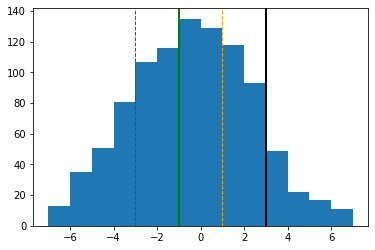

In [11]:
buckets = [x + 1 for x in range(-8,7)]
q1, median, q3 = np.quantile(test_df['home_goal'] - test_df['away_goal'], [0.25, 0.5, 0.75])
plt.hist(test_df['home_goal'] - test_df['away_goal'], bins=buckets)
plt.axvline(q1, color='red', linestyle='dashed', linewidth=1, label='Q1')
plt.axvline(median, color='green', linestyle='solid', linewidth=2, label='Median')
plt.axvline(q3, color='orange', linestyle='dashed', linewidth=1, label='Q3')
plt.axvline(actual_diff.values[0], color='black', linestyle='solid', linewidth=2, label='Q3')


plt.show()